# Sentiment Analysis on IMDb Movie Reviews

In [ ]:
# Import TensorFlow
import tensorflow as tf

# Load Dataset

In [ ]:
import tensorflow_datasets as tfds

# Load the IMDb reviews dataset
imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)
train_data, test_data = imdb['train'], imdb['test']
for feature_name, feature_info in info.features.items():
    print(f"Feature Name: {feature_name}")
    print(f"Feature Type: {feature_info.dtype}")
    print(f"Feature Shape: {feature_info.shape}")
    print("--------------------------")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteJERS4X/imdb_reviews-train.tfrecord…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteJERS4X/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteJERS4X/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


Feature Name: text
Feature Type: <dtype: 'string'>
Feature Shape: ()
--------------------------
Feature Name: label
Feature Type: <dtype: 'int64'>
Feature Shape: ()
--------------------------


# Visualize Data

In [ ]:
for review, label in train_data.take(1):
    print(review.numpy().decode('utf-8'))

This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.


In [ ]:
import pandas as pd

# Initialize lists to store reviews and labels
train_data_reviews = []
train_data_labels = []

# Iterate through the dataset and collect reviews and labels
for review, label in train_data:
    train_data_reviews.append(review.numpy().decode('utf-8'))
    train_data_labels.append(label.numpy())

# Create a dictionary with reviews and labels
data_dict = {
    'Review': train_data_reviews,
    'Label': train_data_labels
}

# Convert the dictionary into a pandas DataFrame
train_data_df = pd.DataFrame(data_dict)

# Display the DataFrame
print(train_data_df.head())

                                              Review  Label
0  This was an absolutely terrible movie. Don't b...      0
1  I have been known to fall asleep during films,...      0
2  Mann photographs the Alberta Rocky Mountains i...      0
3  This is the kind of film for a snowy Sunday af...      1
4  As others have mentioned, all the women that g...      1


In [ ]:
# Initialize lists to store reviews and labels
test_data_reviews = []
test_data_labels = []

# Iterate through the dataset and collect reviews and labels
for review, label in test_data:
    test_data_reviews.append(review.numpy().decode('utf-8'))
    test_data_labels.append(label.numpy())

# Create a dictionary with reviews and labels
data_dict = {
    'Review': test_data_reviews,
    'Label': test_data_labels
}

# Convert the dictionary into a pandas DataFrame
test_data_df = pd.DataFrame(data_dict)

# Display the DataFrame
print(test_data_df.head())

                                              Review  Label
0  There are films that make careers. For George ...      1
1  A blackly comic tale of a down-trodden priest,...      1
2  Scary Movie 1-4, Epic Movie, Date Movie, Meet ...      0
3  Poor Shirley MacLaine tries hard to lend some ...      0
4  As a former Erasmus student I enjoyed this fil...      1


In [ ]:
print(f"Total training samples: {len(train_data_df)}")
print(f"Total test samples: {len(test_data_df)}")
print(f"Total samples: {len(train_data_df) + len(test_data_df)}")

Total training samples: 25000
Total test samples: 25000
Total samples: 50000


# Preprocessing Data


In [ ]:
import math
import nltk
from nltk.corpus import stopwords, wordnet
from bs4 import BeautifulSoup
from nltk.stem import WordNetLemmatizer
import string
import re
from nltk.tokenize import word_tokenize
from nltk import pos_tag

# Download NLTK stopwords list
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')  # Download WordNet corpus if not already downloaded
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
# Before preprocessing
for review, label in train_data.take(5):  # Adjust the number of samples as needed
    print("Review:", review.numpy().decode('utf-8'))
    print("Label:", label.numpy())
    print("-" * 50)

Review: This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.
Label: 0
--------------------------------------------------
Review: I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasi

In [ ]:
def preprocess_text(text):
    # Convert HTML to plain text
    text = BeautifulSoup(text.numpy().decode('utf-8'), "html.parser").get_text()

    # Tokenize the text
    tokens = word_tokenize(text)
    # Lowercase each word
    tokens = [word.lower() for word in tokens]

    # Remove stopwords and non-alphabetic tokens
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]

    # Perform POS tagging on tokens
    tagged_tokens = pos_tag(tokens)
    #print("Tagged Tokens: ", tagged_tokens)

    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word, pos=get_wordnet_pos(tag)) for word, tag in tagged_tokens]

    return ' '.join(tokens)

# Function to map POS tags to WordNet POS tags
def get_wordnet_pos(tag):
    if tag is None:
        return 'n'  # Default to noun if POS tag is None
    elif tag.startswith('J'):
        return 'a'  # Adjective
    elif tag.startswith('V'):
        return 'v'  # Verb
    elif tag.startswith('N'):
        return 'n'  # Noun
    elif tag.startswith('R'):
        return 'r'  # Adverb
    else:
        return 'n'  # Default to noun if POS tag is not recognized

# Remove stopwords and punctuation from combined data
def preprocess_review(review, label):
    processed_text = tf.py_function(func=preprocess_text, inp=[review], Tout=tf.string)
    return processed_text, label

In [ ]:
# Preprocess train_data and test_data
train_data = train_data.map(lambda review, label: preprocess_review(review, label))
test_data = test_data.map(lambda review, label: preprocess_review(review, label))

In [ ]:
# After processing
for review, label in train_data.take(5):
    print("Processed Review:", review.numpy().decode('utf-8'))
    print("Label:", label.numpy())
    print("-" * 50)

Processed Review: absolutely terrible movie lure christopher walken michael ironside great actor must simply worst role history even great act could redeem movie ridiculous storyline movie early ninety u propaganda piece pathetic scene columbian rebel make case revolution maria conchita alonso appear phony affair walken nothing pathetic emotional plug movie devoid real meaning disappointed movie like ruin actor like christopher walken good name could barely sit
Label: 0
--------------------------------------------------
Processed Review: know fall asleep film usually due combination thing include really tired warm comfortable sette eaten lot however occasion fell asleep film rubbish plot development constant constantly slow boring thing seem happen explanation cause admit may miss part film watch majority everything seem happen accord without real concern anything else cant recommend film
Label: 0
--------------------------------------------------
Processed Review: mann photograph albe

# Tokenization

In [ ]:
# Calculate metrics for training data
total_words_train = 0
total_reviews_train = 0
unique_words_train = set()

# Iterate over the training data to calculate metrics
for review, _ in train_data:
    review = review.numpy().decode('utf-8')
    tokens = review.split()
    unique_words_train.update(tokens)
    total_words_train += len(tokens)
    total_reviews_train += 1

# Calculate average word count per review for training data
average_word_count_train = total_words_train / total_reviews_train

# Calculate metrics for testing data
total_words_test = 0
total_reviews_test = 0
unique_words_test = set()

# Iterate over the testing data to calculate metrics
for review, _ in test_data:
    review = review.numpy().decode('utf-8')
    tokens = review.split()
    unique_words_test.update(tokens)
    total_words_test += len(tokens)
    total_reviews_test += 1

# Calculate average word count per review for testing data
average_word_count_test = total_words_test / total_reviews_test

# Print metrics for training data
print("Metrics for training data:")
print("Total words:", total_words_train)
print("Total unique words:", len(unique_words_train))
print("Average word count per review:", average_word_count_train)
print("--------------------------------------------------")

# Print metrics for testing data
print("Metrics for testing data:")
print("Total words:", total_words_test)
print("Total unique words:", len(unique_words_test))
print("Average word count per review:", average_word_count_test)
print("--------------------------------------------------")

total_words = total_words_train+total_words_test
unique_words_dataset = len(unique_words_train | unique_words_test)
average_words_count_total = (total_words_train+total_words_test)/(total_reviews_train+total_reviews_test)

# Print metrics for the dataset
print("Metrics for the dataset:")
print("Total words:", total_words)
print("Total unique words:", len(unique_words_train | unique_words_test))
print("Average word count per review:", average_words_count_total)

max_vocab_length = unique_words_dataset
max_length = math.ceil(average_words_count_total) + 10  # Add a buffer of 10 tokens

<ipython-input-9-28068149879f>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text.numpy().decode('utf-8'), "html.parser").get_text()


Metrics for training data:
Total words: 2851286
Total unique words: 63094
Average word count per review: 114.05144
--------------------------------------------------
Metrics for testing data:
Total words: 2787260
Total unique words: 62274
Average word count per review: 111.4904
--------------------------------------------------
Metrics for the dataset:
Total words: 5638546
Total unique words: 88284
Average word count per review: 112.77092


In [ ]:
# Text Vectorizer Layer
from tensorflow.keras.layers import TextVectorization
text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    standardize=None,
                                    split='whitespace',
                                    ngrams=None,
                                    output_mode="int",
                                    output_sequence_length=max_length,
                                    pad_to_max_tokens=True)

In [ ]:
import random

# Extracting the input texts from the first 10 elements of the training dataset
train_texts = list(train_data.take(10).map(lambda x, y: x).as_numpy_iterator())
# Adapt the TextVectorization layer to the 10 samples of training data
text_vectorizer.adapt(train_texts)

# Choose a random sentence from the 10 samples
random_review = random.choice(list(train_texts))

# Tokenize the random sentence using the TextVectorization layer
random_review_text = random_review.decode('utf-8')
random_review_vectorized = text_vectorizer(tf.expand_dims(random_review_text, -1)).numpy()

print("Random Review Text:", random_review_text)
print("Tokenized Random Review:", random_review_vectorized)
random_review_vectorized.shape

Random Review Text: film see anybody interested effect suffer eat disorder amazingly accurate sensitive portrayal bulimia teenage girl cause symptom girl play one brilliant young actress work cinema today alison lohman later spectacular truth lie would recommend film show school never see good subject alison lohman absolutely outstanding one marvel ability convey anguish girl suffer compulsive disorder barometer tell u air pressure alison lohman tell u emotional pressure degree accuracy emotional range precise scene could measure microscopically gradation trauma scale rise hysteria desperation reach unbearable intensity mare winningham perfect choice play mother immense sympathy range emotion finely tune lohman together make pair sensitive emotional oscillator vibrate resonance one another film really astonishing achievement director katt shea proud reason see interested people even like nature film best animal behaviour sharp edge bulimia extreme version torment soul destroy body fren

(1, 123)

In [ ]:
from tensorflow.keras import layers

# Embedding layer
model_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding")
# Visualize the embedding in the previous random review
sample_embed = model_embedding(text_vectorizer([random_review_text]))
sample_embed, sample_embed.shape

(<tf.Tensor: shape=(1, 123, 128), dtype=float32, numpy=
 array([[[ 0.02038736, -0.00906442, -0.04572121, ...,  0.04925325,
          -0.01360688, -0.01201676],
         [ 0.01014944, -0.01747749, -0.00638852, ..., -0.01821102,
           0.01863518,  0.04474398],
         [-0.03519597, -0.00315984,  0.00394183, ...,  0.02328404,
           0.01179316,  0.00211591],
         ...,
         [-0.00685563,  0.0248098 , -0.02909597, ...,  0.01401788,
           0.01856213, -0.0267713 ],
         [ 0.02038736, -0.00906442, -0.04572121, ...,  0.04925325,
          -0.01360688, -0.01201676],
         [-0.03589358, -0.04385486,  0.00193547, ...,  0.0476766 ,
          -0.04692116,  0.0377063 ]]], dtype=float32)>,
 TensorShape([1, 123, 128]))

# Prepare for training

In [ ]:
import pandas as pd

# Initialize lists to store reviews and labels
new_train_data_reviews = []

# Iterate through the dataset and collect reviews and labels
for review, label in train_data:
    new_train_data_reviews.append(review.numpy().decode('utf-8'))

# Create a dictionary with reviews and labels
data_dict = {
    'Review': new_train_data_reviews,
    'Label': train_data_labels
}

# Convert the dictionary into a pandas DataFrame
train_data_df = pd.DataFrame(data_dict)

# Display the DataFrame
print(train_data_df.head())

<ipython-input-9-28068149879f>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text.numpy().decode('utf-8'), "html.parser").get_text()


                                              Review  Label
0  absolutely terrible movie lure christopher wal...      0
1  know fall asleep film usually due combination ...      0
2  mann photograph alberta rocky mountain superb ...      0
3  kind film snowy sunday afternoon rest world go...      1
4  others mention woman go nude film mostly absol...      1


In [ ]:
import pandas as pd

# Initialize lists to store reviews and labels
new_test_data_reviews = []

# Iterate through the dataset and collect reviews and labels
for review, label in test_data:
    new_test_data_reviews.append(review.numpy().decode('utf-8'))

# Create a dictionary with reviews and labels
data_dict = {
    'Review': new_test_data_reviews,
    'Label': test_data_labels
}

# Convert the dictionary into a pandas DataFrame
train_data_df = pd.DataFrame(data_dict)

# Display the DataFrame
print(train_data_df.head())

<ipython-input-9-28068149879f>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text.numpy().decode('utf-8'), "html.parser").get_text()


                                              Review  Label
0  film make career george romero night live dead...      1
1  blackly comic tale priest nazarin showcase eco...      1
2  scary movie epic movie date movie meet spartan...      0
3  poor shirley maclaine try hard lend gravitas m...      0
4  former erasmus student enjoy film much realist...      1


In [ ]:
# Shuffle training texts
train_data_shuffled_df = train_data_df.sample(frac=1.0, replace=False, random_state=42)
train_data_shuffled_df

,Review,Label
6868,crazy amber smith see besides svelte body pret...,0
24016,show great many reason father mother communica...,1
9668,honestly find wicked little thing cool fun hor...,1
13640,straight happy main center movie story lady mo...,0
14018,film interest sensitive period history film be...,0
...,...,...
21575,touch movie story special bond child grandfath...,1
5390,treat fan movie find write act bad enough riva...,0
860,saw film many time every time disappointed sha...,0
15795,finally get chance settle compare two version ...,1


In [ ]:
train_data_reviews = train_data_shuffled_df['Review']
test_data_reviews = test_data_df['Review']

train_data_labels = train_data_shuffled_df['Label']
test_data_labels = test_data_df['Label']

# Model Architecture with Custom Embedding Layer

## LSTMs Model

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Define callbacks
checkpoint_callback = ModelCheckpoint(filepath='model_checkpoint.tf',
                                      monitor='val_binary_accuracy',
                                      save_best_only=True,
                                      verbose=1)
early_stopping_callback = EarlyStopping(monitor='val_binary_accuracy',
                                        patience=3,
                                        verbose=1)

In [ ]:
# Set random seed
tf.random.set_seed(42)
from tensorflow.keras import layers, models

# Build an RNN
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_embedding(x)

x = layers.LSTM(128, return_sequences=True)(x)
x = layers.LSTM(64, return_sequences=False)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.2)(x)

# Output layer
outputs = layers.Dense(1, activation='sigmoid')(x)

# Define the model
model = models.Model(inputs, outputs)

# Compile model
model.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics= tf.metrics.BinaryAccuracy())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 123)               0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 123, 128)          11300352  
                                                                 
 lstm_2 (LSTM)               (None, 123, 128)          131584    
                                                                 
 lstm_3 (LSTM)               (None, 64)                49408     
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                           

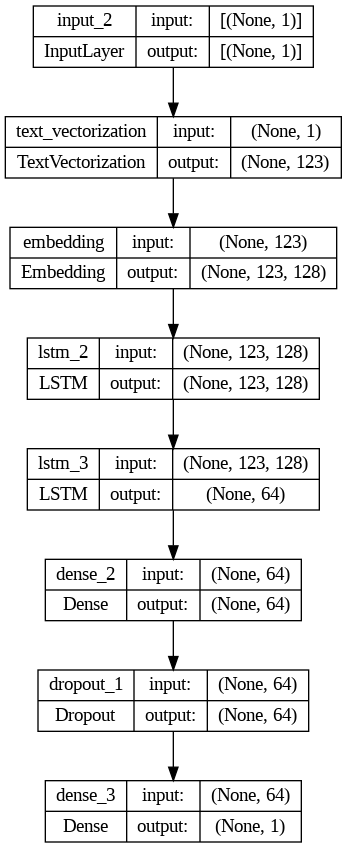

In [ ]:
from tensorflow.keras.utils import plot_model
model.summary()
# Plot the model architecture
plot_model(model, to_file='model_architecture.png', show_shapes=True)

In [ ]:
# Train model
history = model.fit(train_data_reviews,
                    train_data_labels,
                    epochs=20,
                    batch_size=32,
                    validation_data=(test_data_reviews, test_data_labels),
                    callbacks=[checkpoint_callback, early_stopping_callback]
                    )

Epoch 1/20
782/782 [==============================] - ETA: 0s - loss: 0.6604 - binary_accuracy: 0.5633
Epoch 1: val_binary_accuracy improved from 0.50668 to 0.66732, saving model to model_checkpoint.tf
782/782 [==============================] - 36s 40ms/step - loss: 0.6604 - binary_accuracy: 0.5633 - val_loss: 0.6153 - val_binary_accuracy: 0.6673
Epoch 2/20
782/782 [==============================] - ETA: 0s - loss: 0.5033 - binary_accuracy: 0.7544
Epoch 2: val_binary_accuracy improved from 0.66732 to 0.70328, saving model to model_checkpoint.tf
782/782 [==============================] - 30s 39ms/step - loss: 0.5033 - binary_accuracy: 0.7544 - val_loss: 0.5639 - val_binary_accuracy: 0.7033
Epoch 3/20
782/782 [==============================] - ETA: 0s - loss: 0.4807 - binary_accuracy: 0.7678
Epoch 3: val_binary_accuracy did not improve from 0.70328
782/782 [==============================] - 23s 30ms/step - loss: 0.4807 - binary_accuracy: 0.7678 - val_loss: 0.5873 - val_binary_accuracy: 0

## Bidirectional Layer Model

In [ ]:
# Set random seed
tf.random.set_seed(42)

# Build an RNN
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_embedding(x)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(32, return_sequences=False))(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dropout(0.3)(x)

# Output layer
outputs = layers.Dense(1, activation='sigmoid')(x)

# Define the model
model_2 = models.Model(inputs, outputs)

# Compile model
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics= tf.metrics.BinaryAccuracy())

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 123)               0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 123, 128)          11300352  
                                                                 
 bidirectional_3 (Bidirecti  (None, 123, 128)          98816     
 onal)                                                           
                                                                 
 bidirectional_4 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                           

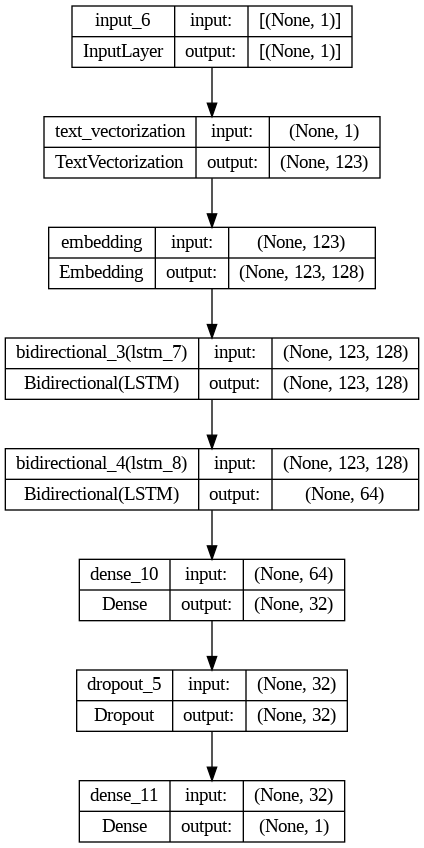

In [ ]:
from tensorflow.keras.utils import plot_model
model_2.summary()
# Plot the model architecture
plot_model(model_2, to_file='model_architecture.png', show_shapes=True)

In [ ]:
# Train model
history = model_2.fit(train_data_reviews,
                      train_data_labels,
                      epochs=20,
                      batch_size=32,
                      validation_data=(test_data_reviews, test_data_labels),
                      callbacks=[checkpoint_callback, early_stopping_callback]
                      )

Epoch 1/20
782/782 [==============================] - ETA: 0s - loss: 0.5193 - binary_accuracy: 0.7462
Epoch 1: val_binary_accuracy did not improve from 0.71620
782/782 [==============================] - 41s 44ms/step - loss: 0.5193 - binary_accuracy: 0.7462 - val_loss: 0.5577 - val_binary_accuracy: 0.7002
Epoch 2/20
782/782 [==============================] - ETA: 0s - loss: 0.4670 - binary_accuracy: 0.7799
Epoch 2: val_binary_accuracy did not improve from 0.71620
782/782 [==============================] - 31s 39ms/step - loss: 0.4670 - binary_accuracy: 0.7799 - val_loss: 0.6129 - val_binary_accuracy: 0.6215
Epoch 3/20
782/782 [==============================] - ETA: 0s - loss: 0.4638 - binary_accuracy: 0.7822
Epoch 3: val_binary_accuracy did not improve from 0.71620
782/782 [==============================] - 31s 40ms/step - loss: 0.4638 - binary_accuracy: 0.7822 - val_loss: 0.5611 - val_binary_accuracy: 0.7123
Epoch 4/20
782/782 [==============================] - ETA: 0s - loss: 0.4609

## GRU Model

In [ ]:
# Set random seed
tf.random.set_seed(42)
from tensorflow.keras import layers, models

# Build an RNN
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_embedding(x)

x = layers.GRU(64, return_sequences=True)(x)
x = layers.GRU(32, return_sequences=False)(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dropout(0.2)(x)

# Output layer
outputs = layers.Dense(1, activation='sigmoid')(x)

# Define the model
model_3 = models.Model(inputs, outputs)

# Compile model
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics= tf.metrics.BinaryAccuracy())

In [ ]:
# Train model
history = model_3.fit(train_data_reviews,
                      train_data_labels,
                      epochs=20,
                      batch_size=32,
                      validation_data=(test_data_reviews, test_data_labels),
                      callbacks=[checkpoint_callback, early_stopping_callback]
                      )

Epoch 1/20
782/782 [==============================] - ETA: 0s - loss: 0.6907 - binary_accuracy: 0.5178
Epoch 1: val_binary_accuracy did not improve from 0.71620
782/782 [==============================] - 29s 32ms/step - loss: 0.6907 - binary_accuracy: 0.5178 - val_loss: 0.6874 - val_binary_accuracy: 0.5276
Epoch 2/20
782/782 [==============================] - ETA: 0s - loss: 0.4981 - binary_accuracy: 0.7626
Epoch 2: val_binary_accuracy did not improve from 0.71620
782/782 [==============================] - 23s 30ms/step - loss: 0.4981 - binary_accuracy: 0.7626 - val_loss: 0.5473 - val_binary_accuracy: 0.7134
Epoch 3/20
782/782 [==============================] - ETA: 0s - loss: 0.4673 - binary_accuracy: 0.7806
Epoch 3: val_binary_accuracy did not improve from 0.71620
782/782 [==============================] - 23s 29ms/step - loss: 0.4673 - binary_accuracy: 0.7806 - val_loss: 0.5918 - val_binary_accuracy: 0.6648
Epoch 4/20
782/782 [==============================] - ETA: 0s - loss: 0.4644

# Evaluate the Best Model

In [ ]:
# Load the best models from the SavedModel format
loaded_model = tf.keras.models.load_model('model_checkpoint.tf')

In [ ]:
# Make predictions with our bidirectional model
model_preds = loaded_model.predict(test_data_df['Review'])
print("Best Model:")
print(f"Predictions: {model_preds}, Shape: {model_preds.shape}")

782/782 [==============================] - 7s 8ms/step
Best Model:
Predictions: [[0.23968635]
 [0.583391  ]
 [0.5782252 ]
 ...
 [0.06198484]
 [0.64408135]
 [0.8170276 ]], Shape: (25000, 1)


In [ ]:
# Convert pred probs to labels for first Model
model_preds = tf.squeeze(tf.round(model_preds))
model_preds, model_preds.shape

(<tf.Tensor: shape=(25000,), dtype=float32, numpy=array([0., 1., 1., ..., 0., 1., 1.], dtype=float32)>,
 TensorShape([25000]))

In [ ]:
import numpy as np

# Define a threshold for binary classification
threshold = 0.5

# Convert probabilities to binary predictions using the defined threshold
binary_preds = np.where(model_preds >= threshold, 1, 0)

# Display the binary predictions
print("Binary Predictions for first model:", binary_preds)

Binary Predictions for first model: [0 1 1 ... 0 1 1]


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

true_labels = test_data_df['Label'].values

# Calculate accuracy
accuracy = accuracy_score(true_labels, binary_preds)

# Calculate precision
precision = precision_score(true_labels, binary_preds, average="weighted")

# Calculate recall
recall = recall_score(true_labels, binary_preds, average="weighted")

# Calculate F1-score
f1 = f1_score(true_labels, binary_preds, average="weighted")

print("Best Model Metrics:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Best Model Metrics:
Accuracy: 0.7162
Precision: 0.716512644258309
Recall: 0.7162
F1-score: 0.7160975112015436
